# Creating RAG agent parts for price identification

The objective on this notebook is to create the parts for the RAG agent to identify prices!

The previous notebook can be found: [`experiments/rag.ipynb`](rag.ipynb).

This notebook will be divided on multiple sections, for a union on the final experiment.

---

Importing packages:

In [26]:
!pip install ipython

In [27]:
from langchain_core.messages import AnyMessage, AIMessage, HumanMessage, SystemMessage

from langgraph.graph import StateGraph, START, END

from IPython.display import display, Image

from re import search

from typing import TypedDict, Literal

In [28]:
%cd ..

/home/gabael/projetos


In [29]:
from src.ollama.llm import chat
from src.rag.rag import web_search_rag, generate_vector_store

---

# Identify if the query is for product web search

If the user sends a query, the agent need to see if the query is for a product web search or is a invalid search.

In [30]:
assistant_instruction_identifier_validity = SystemMessage(
    content="""Você é um assistente especializado em identificar se a entrada recebida é passível de processamento. Para uma entrada ser processada, é necessário que ela possa ser utilizada para buscar preços. Para verificar se uma entrada pode ser usada para buscar preços, verifique se a entrada pode participar das seguintes categorias:
    
    Categorias válidas:
    - Celular;
    - Televisão;
    - Lavador;
    - Notebook;
    - Geladeira;
    - Ar-Condicionado;
    - Fogão;
    - Eletrodomésticos;
    - Eletroportáteis;
    - Informática.
    
    Caso a entrada participe de quaisquer categoria, pode ser considerada uma entrada válida. Se este for o caso, especifique a categoria. Se não, apenas especifique que não é uma entrada válida e não gere uma resposta.""" 
)

In [31]:
user_example_1 = HumanMessage(
    content="Qual a idade do atual presidente do brasil?"
)

ai_example_1 = AIMessage(
    content="Entrada inválida."
)

In [32]:
user_example_2 = HumanMessage(
    content="Qual o preço de um ar condicionado?"
)

ai_example_2 = AIMessage(
    content="Categoria: Ar-condicionado."
)

In [33]:
user_example_3 = HumanMessage(
    content="Qual o preço de um carro?"
)

ai_example_3 = AIMessage(
    content="Entrada inválida."
)

In [34]:
user_example_4 = HumanMessage(
    content="Qual é o motivo da chuva?"
)

ai_example_4 = AIMessage(
    content="Entrada inválida."
)

In [35]:
message_example = HumanMessage("Qual o preço de um celular A30?")

In [56]:
identify_valid_query = chat.invoke([
    assistant_instruction_identifier_validity, 
    user_example_1, 
    ai_example_1,
    user_example_2,
    ai_example_2,
    user_example_3,
    ai_example_3,
    user_example_4,
    ai_example_4,
    message_example])

In [57]:
print(identify_valid_query.content)

Categoria: Celular.


---

# Identify the product

From user query, identify the product search 

In [36]:
assistent_identify_product = SystemMessage(
    content="""Você é um assistente especializado em identificar qual é o produto especificado para busca de preços a partir da entrada.
    
    Exemplos:
    Entrada: Eu quero o preço de um ar condicionado 5500 btu.
    Saída: ar condicionado 5500 btu.
    
    Entrada: Eu preciso de um novo celular, com o objetivo de poder ligar para meus netos.
    Saída: Celular.
    
    Entrada: Estou procurando um fogão para alimentar minha família, com 4 bocas.
    Saída: Fogão 4 bocas""" 
)

In [37]:
message_example = HumanMessage("Eu preciso de uma geladeira para guardar meus alimentos. Ela precisa ser pequena e ter 200L de volume")

In [ ]:
identify_product_query = chat.invoke([
    assistent_identify_product,
    message_example
    ])

In [27]:
identify_product_query.content

'Geladeira pequena de 200L de volume.'

---

# Final Agent

Use rag tools to identify prices.

Define graph's schema:

In [82]:
class InputState(TypedDict):
    query: str

In [83]:
class CategoryState(TypedDict):
    query: str
    category: str

In [84]:
class ProductState(TypedDict):
    query: str
    category: str
    product: str

In [85]:
class PriceState(TypedDict):
    price: str

In [86]:
class OutputState(TypedDict):
    answer: str

In [87]:
class OverallState(TypedDict):
    query: str
    category: str
    product: str
    price: str
    answer: str

Define nodes:

In [88]:
def generate_category(input_state: InputState) -> CategoryState:
    
    user_msg = HumanMessage(content=input_state['query'])

    answer = chat.invoke([
        assistant_instruction_identifier_validity, 
        user_example_1, 
        ai_example_1,
        user_example_2,
        ai_example_2,
        user_example_3,
        ai_example_3,
        user_example_4,
        ai_example_4,
        user_msg
    ])

    category = str(answer.content)

    return {'query': input_state['query'], 'category': category}

In [89]:
def generate_product(category_state: CategoryState) -> ProductState:

    user_msg = HumanMessage(category_state['query'])

    answer = chat.invoke([
        assistent_identify_product,
        user_msg
    ])

    product = str(answer.content)

    return {
        'category': category_state['category'],
        'product': product,
        'query': category_state['query']
    }

In [90]:
def generate_price(product_state: ProductState) -> PriceState:

    vector_store = generate_vector_store(product_state['product'])

    retrieval = web_search_rag(vector_store, 10, product_state['query'])

    assistant_rag = SystemMessage(content=f"""Você é um assistente especializado em realizar pesquisas de preço. Responda apenas com o preço e onde comprar.
                                  
                                  Utilize esta base de conhecimento: {retrieval}.""")
    
    user_msg = HumanMessage(product_state['query'])

    answer = chat.invoke([
        assistant_rag,
        user_msg
    ])

    price = str(answer.content)

    return {'price': price}

In [91]:
PATTERN_URL = r"(www.zoom.com.br)"

def generate_answer(price_state: PriceState) -> OutputState:

    if search(PATTERN_URL, price_state['price']): return {'answer': price_state['price']}

    answer = price_state['price'] + '\n' + "Fonte: " + "www.zoom.com.br."

    return {'answer': str(answer)}

In [92]:
def generate_error_message(category_state: CategoryState) -> OutputState:

    answer = """Eu não posso resolver o seu pedido, pois eu sou especializado em identificar preços para produtos das seguintes categorias: Celular; Televisão; Lavador; Notebook; Geladeira; Ar-Condicionado; Fogão; Eletrodomésticos; Eletroportáteis; Informática.
    """

    return {'answer': answer}

Define conditional edges:

In [93]:
PATTERN_INVALID_CATEGORY = r"(Entrada inválida.)"

def verify_category_state(category_state: CategoryState) -> Literal["error-node", "product-node"]:
    if search(PATTERN_INVALID_CATEGORY, category_state["category"]):
        return "error-node"
    return "product-node"

Define graph:

In [94]:
builder = StateGraph(OverallState, input_schema=InputState, output_schema=OutputState)

In [95]:
builder.add_node("category-node", generate_category)
builder.add_node("product-node", generate_product)
builder.add_node("price-node", generate_price)
builder.add_node("answer-node", generate_answer)
builder.add_node("error-node", generate_error_message)

In [96]:
builder.add_edge(START, "category-node")
builder.add_conditional_edges("category-node", verify_category_state)
builder.add_edge("product-node", "price-node")
builder.add_edge("price-node", "answer-node")
builder.add_edge("answer-node", END)
builder.add_edge("error-node", END)

In [97]:
graph = builder.compile()

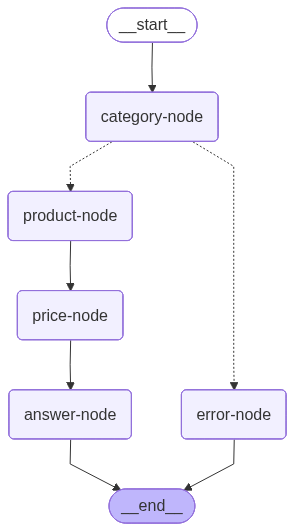

In [98]:
display(Image(graph.get_graph().draw_mermaid_png()))

# Test the graph!

In [105]:
INPUT = "Eu quero comprar uma TV sansung 4k"

In [106]:
answer = graph.invoke({"query": INPUT})

In [107]:
print(answer['answer'])

Para encontrar a melhor TV Samsung 4K disponível no mercado, farei uma pesquisa por você.

Aqui estão algumas opções:

1. **TV Samsung 43" 4K UHD HDR UN43TU8000**: Preço: R$ 2.209,00 (até 10x de R$ 220,90) - Disponível em Casas Bahia.
2. **TV Samsung 55" 4K UHD HDR QN65Q60CAGXZDM**: Preço: R$ 5.593,39 (até 12x de R$ 490,65) - Disponível em Casas Bahia.
3. **TV Samsung 65" 4K UHD HDR UN65TU8000**: Preço: R$ 6.583,06 (até 8x de R$ 914,31) - Disponível em Americanas.

É importante notar que os preços podem variar dependendo da loja e do modelo específico que você estiver procurando.

Para ter mais opções e preços atualizados, eu sugiro que você vá ao site das lojas de eletrônicos mencionadas acima (Casas Bahia, Amazon, Magazine Luiza) ou visite físicamente as lojas para comparar os preços e modelos disponíveis. Além disso, é sempre uma boa ideia ler as avaliações e comentários de outros clientes para ter uma ideia melhor da qualidade e desempenho da TV antes de fazer a compra.
Fonte: www.

In [102]:
BAD_INPUT = "Quantos anos uma rosa consegue ficar viva?"

In [103]:
bad_answer = graph.invoke({"query": BAD_INPUT})

In [104]:
print(bad_answer['answer'])

Eu não posso resolver o seu pedido, pois eu sou especializado em identificar preços para produtos das seguintes categorias: Celular; Televisão; Lavador; Notebook; Geladeira; Ar-Condicionado; Fogão; Eletrodomésticos; Eletroportáteis; Informática.
    
